## <center> CS-E4890 - Deep Learning, Project Work</center>
## <center> Jointed Convolutional and Recurrent Neural Network for Sentiment Analysis </center>
## <center> Teamname: SY</center>
## <center> date: May 18th, 2019</center>

# 1. Introduction

Sentiment analysis is a hot application of text mining that identifies and extracts contextual information in raw text and helps companies to understand the users' opinion of their product or service. It often integrates with recommender system in business. In recent years, deep learning models show its impressive performance on natural language processing and in this project, we would cover the topic of sentiment analysis and implement deep learning model on two different review dataset to recognize and classify user's social sentiment on products.

Section 1. Problem and data description (3 pts)

1.1. The report should describe the problem and/or research questions addressed in the project. (1 pt)

* It is unclear what problem the project tries to solve.
* The problem is described but some details are missing.
* The problem is described well.

1.2. Bonus: Is the problem novel and/or original? (1 pt)

* No
* Yes

1.3 Data description. (1 pt)
Describe data dimensionalities, number of training samples, the format used.

* The data is not described.
* The data is described but some details are missing.
* The data is described well.

1.4. Please describe what details were missing in the problem/data description.

## 1.1 Problem

The challenge we are aiming to solve is to predict the overall score/sentiment of the review, given by the user, based on the review itself. We choose to extrapolate the word embeddings from the raw text using different methods and treat these with a jointed convolutional and recurrent neural network to examine the performance of our model and evaluate our prediction.

## 1.2 Dataset

We would carry out the experiment on two dataset, one is multiclass and the other is binary and compare the performance of model between these two. The datasets have several fields, and each sample corresponds to one label. Only review text and corresponding label are needed in our experiment. 

### 1.2.1 Multiclass dataset
Taken from the Amazon Product data$^{1}$ that collects opinions of users shared on the Amazon Prime platform, the dataset we are working on is concerned with instant video contents. The original data has been reduced in order to extract and each observation has a label of rating, which ranges from 1 to 5 and can be regarded as very negative, negative, neutral, postive, very postive for opinion. The dataset uses .json.gz format and we use specific functions to load it.  

The dense dataset made so far has 9 fields: 

In [4]:
%reload_ext autoreload
%autoreload 2

from ReviewModel import ReviewModel
from dataLoader import *
import numpy as np
import torch

In [5]:
data_loader = AmznDataLoader(path ='./data/reviews_Amazon_Instant_Video_5.json.gz', maxSeqLength = 60)
data_loader.info

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,2.0,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,5.0,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,1.0,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,4.0,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",5.0,Robson green and great writing,1234310400,"02 11, 2009"


More in detail:
- reviewerID - ID of the reviewer
- asin - ID of the product
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

### 1.2.2 Twoclass dataset

The other dataset we use is SST2 with binary labels, which is taken from Stanford Sentiment Treebank$^2$ SST1 after removing neutral review. The data is saved as .txt files and only contains label and reviewtext.

Here is the summary for two dataset. 

| Data      | Class | MaxSeqLength | #Observations | #Corpus |# Words cannot found| #Train |#Test| TrainValSplit |
|--------------|-------|--------------|---------------|---------|-|----------------|---------------|
| AmazonReview | 5     | 60           | 37,126    | 52,656 |376 |29,700  |  7,426    |      4:1      |
| SST2         | 2     | 20           |    8,741     | 15,017  |9,776 |6,992  |  1,749|    4:1  |

Section 2. Method (6 pts)

2.1. Method description. (2 pts)

The report should describe well the model used in the project. If the model was covered in the lectures, it is ok to describe the architecture (such as, e.g., the number of layers etc) without going into details (such as computations in a basic convolutional layer). If the model was not covered in the lectures, you need to provide enough details so that your classmates can understand it without checking external references.

* The model is not described.
* The model is described well but some details are missing.
* The model is described very well. I could implement the model based on the description.

2.2. Choice of the model. (2 pts)

* The proposed model is not reasonable for the task.
* The model is reasonable but some choices are questionable.
* The model is suitable for the task.

2.3. Bonus: Is the model novel and/or original? (2 pts)

* No
* Partly
* Yes, the model deserves to be presented in a conference

2.4. If you think that the model is not perfectly suitable for the task, plea	


# 2. Method

## 2.1 Method Description

In this section we would present the details of model architecture and used techniques. The model utilizes layers including
- CNN(Convolutional Neural Network) and GRU(Gated Recurrent Unit)
- Maxpooling, Dropout and Linear Layers
- activation Relu, logsoftmax.

All layers are 1-d. 

The model is reproduced according to Jiang$^{4}$et al.,(2016), which combines the advantages of CNN and RNN for sentiment analysis for short text with the advantages of CNN's characteristic of preserving local features with order and RNN's long term dependencies of features. The model shows remarkable classification accuracy, and we would develop it in pytorch for our amazon dataset and compare the result of SST2 dataset with that of the paper. 

### 2.1.1 Word Embedding

Word embedding is one of popular vocabulary representations and efficient way of proprecessing raw text, which aims to capturing words in a text while keeping their semantic and syntactic similarity and represented words by high-dimensional vectors, so each word in the corpus is assigned as a unique vector. Commonly it is generated by random initialization or pretrained by unsupervised learning algorithm. Here we used glove$^3$ released by Stanford and random embedding and compare their effects on results. The pretrained models should contain most common words, and we initialize random embedding for those words cannot found.

The powerful function of word embedding is that the distance of two vectors in vector space
is the sign of the similarity of meaning/context of words. An example of words vector that projected on 2D space after dimensionality reduction is given below to help understanding. We used word embedding to convert text to vector for further feature extraction by Convolution.

<img src="man_woman.jpg" style="width:400px;" alt="Drawing" align="center"/>

In our project, the text is transformed to 50-dim word embedding to prevent simplicity of meaning and represents as matrix, where each word/vector is regarded as one feature. Let l and d be the maximum length of sentence and word vector, the matrix can be written as $C \in \mathbb{R}^{d*l}$, and each column $C_i \in \mathbb{R}^{d}$ represents word embedding for i$^{th}$ word in the sentence text, **Note that in the model $C \in \mathbb{R}^{l*d}$ swaps for valid input of embedding layer, so is the following dimensionality**.

### 2.1.2 Convolution and MaxPooling

CNN has advantage to maintain information of local features and their order and maxpooling is able to select the important features. We would apply this combination to word embedding. Two convolutions with kernel size $H \in \mathbb{R}^{d*w}$ of one difference is applied to the sentence matrix obtained above with zero padding on both sides to produce feature map $c = [c_1, c_2, ..., c_{l-w+2*p+1}]$, for each feature 

\begin{equation*}
c_i = \sigma (\sum (C[-1, i:i+w])\circ H)+b)
\end{equation*}

$b\in \mathbb{R}, \sigma$ represents bias and non-linear activation function respectively, and we use Relu as activation. $\circ$ represent element-wise multiplication or Hadamard product between two matrices. $p$ corresponds to the number of zero padding on both sides, p = 2. $C[-1,i:i+w]$ correponds to $i^{th}$ to $i+w^{th}$ words/vectors in the sentence.

The windows with different length moves from left to right of the sentence to keep its sequential context in feature map and sebsequent maxpooling layer capture important features. The additional zero padding helps retain information on the edge as much as poosible. The outputs of convolutional layer should have one difference in one dimension for one kernel size = 4 and the other kernel size = 5 while stride = 1 and padding = 2 are retained same, and a pair of the maxpooling layers with kernel_size = 2 enables the feature map downscaled by 2, that is, to get rid of difference and make it consistent, hence $\text{maxpooling} (c) \in \mathbb{R}^{\lfloor \frac{l-w+2p+1}{2} \rfloor}$.

Assuming we would use m weight matrices to get feature maps, hence after maxpooling layer it would produce feature maps $P\in \mathbb{R}^{\lfloor \frac{l-w+2p+1}{2} \rfloor*m}$. Here m is the outchannels for convolution, i.e., m = 200.

### 2.1.3 GRU

GRU was introduced by Cho et al.(2014) firstly and we use it to handle with long-term dependencies of features of inputs. The key equations for updating GRU is displayed below.

<center>$ h_t = (1-z_t)\circ h_{t-1} + z\circ \hat{h_t}\\
r_t = \sigma(U_r h_{t-1} + W_r x_t)\\
u_t = \sigma(U_z h_{t-1} + W_z x_t )\\
\hat{h_t} = \phi(W x_t + U(r_t \circ h_{t-1}))
$<center>.

$\sigma$ denotes log_sigmoid functcion, and $r_t$, $z_t$ and $\hat{h_t}$ denotes reset gate, update gate and new hidden layer. 

We would concatenate adjacent feature maps $P_1$ and $P_2$ before feeding it to GRU layer. The output should be $Z = (P_1,P_2) \in \mathbb{R}^{\lfloor \frac{l-w+2p+1}{2} \rfloor*2m} $, the convolutional output of one sentence.The GRU is one layer and one direction, and we set the features h in the initial hidden state for each element, and we only retain the output features from the last layer, therefore the output of one sentence $h_t\in \mathbb{R}^{\lfloor \frac{l-w+2p+1}{2} \rfloor*h}$.Here we set hidden size h = 100. 

### 2.1.4 Classifier 

Finally we pass the output $h_t$ of final layer from GRU to a classifier that consists of two fully connected linear layers, and the output is the probability distribution over all classes. We would use CrossEntropyLoss function to measure the inconsistency between predicted and actual output. 

Note that in pytorch CrossEntropyLoss integrates logsoftmax with NLLLoss function already so we don't have to add softmax activation for final layer. Here is the loss for one input.

<center>loss(x,class) = $-\log(\frac{\exp(x[class])}{\sum_j \exp(x[j])}) = -x[class] + \log (\sum_j exp(x[j])) $<center>

The model is trained by different learning rate and optimizer to prevent stop at local minimum and achieve higher accuracy. The details can be found in the latter section. We use skorch package that wraps pytorch with sklearn interface. The dropout layers are used in our model to prohibit overfitting as well.  

## Improvements

# Experiments and Results

Section 3. Experiments and results (4 pts)

3.1. Are the experiments described well in the report? (2 pts)

* The experiments are not described.
* Experiments are described but some details are missing.
* Experiments are well described. I could reproduce the experiments based on the description.

3.2. Performance of the proposed model (2 pts)

* It is difficult to evaluate the performance (there is no baseline or no demo for tasks that require subjective evaluation).
* The results are adequate.
* The results are impressive (either close to the state of the art or good subjective evaluation).

3.3. Suggest what could be improved in the experiments.

## 3. Experiments

Next we would train our model using two dataset with two different word embedding method. To train our model, we have to change certain paramaters to fit model: For changing dataset,you have to modify output_dim and max_length; For changing embedding mode, you have to modify random. 

In [6]:
ReviewModelParam = {
    "max_length": 60,
    "embedding_dim": 50,
    "vocab_length" : data_loader.weight_matrix.shape[0],
    "output_dim" : 5,
    "batch_size" : 128,
    "random":False,
    "first_dropout" : 0.5,
    "conv_input_channel": None,
    "conv_output_channel" : 200,
    "conv_padding" : 2,
    "conv1_kernel_size" : 4,
    "conv2_kernel_size" : 5,
    "maxpool_kernel_size" : 2,
    "second_dropout" : 0.3,
    "rnn_input_size": None,
    "rnn_hidden_size" : 100,
    "rnn_num_layers" : 1,
    "first_dense_in":None,
    "first_dense_out" : 400,
    "third_dropout" : 0.15,
    "second_dense_in" : None,
    "second_dense_out" : None
    }

ReviewModelParam["conv_input_channel"] = ReviewModelParam["embedding_dim"]
ReviewModelParam["rnn_input_size"] = ReviewModelParam["conv_output_channel"]*2
ReviewModelParam["first_dense_in"] = ReviewModelParam["max_length"]//2 * ReviewModelParam["rnn_hidden_size"]
ReviewModelParam["second_dense_in"] = ReviewModelParam["first_dense_out"]
ReviewModelParam["second_dense_out"] = ReviewModelParam["output_dim"] 

In [7]:
from skorch import NeuralNetClassifier
import torch.optim as optim
from skorch.callbacks import EpochScoring,LRScheduler, EarlyStopping
from torch import nn

### 3.1 Multiclass dataset with glove embedding

In [8]:
callbacks = [
    ('es1',EpochScoring('accuracy')),
    ('lrs',LRScheduler()),
    ('est',EarlyStopping())    
]
batch_size = 128
device = torch.device("cuda")
model = ReviewModel(ReviewModelParam).to(device)
net = NeuralNetClassifier(model,
                          iterator_train__drop_last = True,
                          iterator_valid__drop_last = True, 
                          iterator_train__shuffle = True,
                          iterator_valid__shuffle = True,
                          max_epochs=100, 
                          criterion = nn.CrossEntropyLoss,
                          optimizer=optim.Adam,
                          lr = 0.01,
                          batch_size = batch_size,
                          callbacks = callbacks,
                          device = device,verbose = 1
                          )

In [9]:
inputs = torch.from_numpy(data_loader.X_train).long().to(device)
labels = torch.tensor(data_loader.y_train.values).long().to(device)
net.fit(inputs, labels)

  epoch    accuracy    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.5623        2.0095       0.5623        1.2016  76.6751
      2      0.5618        1.3627       0.5618        1.2021  76.3936
      3      0.5617        1.2028       0.5617        1.2021  76.3208
      4      0.5603        1.2028       0.5603        1.2042  76.4225
      5      0.5606        1.2027       0.5606        1.2037  76.4804
Stopping since valid_loss has not improved in the last 5 epochs.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ReviewModel(
    (embedding): Embedding(52655, 50)
    (drop1): Dropout(p=0.5)
    (conv1): Conv1d(50, 200, kernel_size=(4,), stride=(1,), padding=(2,))
    (conv2): Conv1d(50, 200, kernel_size=(5,), stride=(1,), padding=(2,))
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop2): Dropout(p=0.3)
    (rnn): GRU(400, 100)
    (fc1): Linear(in_features=3000, out_features=400, bias=True)
    (drop3): Dropout(p=0.15)
    (fc2): Linear(in_features=400, out_features=5, bias=True)
  ),
)

The table above shows the training of the first dataset with glove embeddings. As we can see the results are not promising:
in fact the training loss is not recreasing, and the validation loss as well. It seems that the net is not learning at all. It may be due to the fact the dataset is imbalanced as it will be discussed later.

In [18]:
inputs = torch.from_numpy(data_loader.X_test).long().to(device)
predictions = net.predict(inputs)

Text(33.0, 0.5, 'True label')

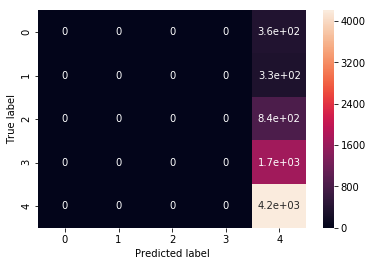

In [31]:
import seaborn as sns
cm = sklearn.metrics.confusion_matrix(data_loader.y_test[:-2], predictions)
sns.heatmap(cm,annot = True)
plt.xlabel("Predicted label")
plt.ylabel("True label")

### 3.2 Multiclass dataset with random embedding

In [32]:
ReviewModelParam["random"] = True

In [33]:
model = ReviewModel(ReviewModelParam).to(device)
net = NeuralNetClassifier(model,## change dimensionality
                          iterator_train__drop_last = True,
                          iterator_valid__drop_last = True, 
                          iterator_train__shuffle = True,
                          iterator_valid__shuffle = True,
                          max_epochs=100, 
                          criterion = nn.CrossEntropyLoss,
                          optimizer=optim.Adam,
                          lr = 0.01,
                          batch_size = batch_size,
                          callbacks = callbacks,
                          device = device,verbose = 1
                          )

In [34]:
inputs = torch.from_numpy(data_loader.X_train).long().to(device)
labels = torch.tensor(data_loader.y_train.values).long().to(device)
net.fit(inputs, labels)

  epoch    accuracy    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.5615        4.2108       0.5615        1.2034  76.3468
      2      0.5615        1.2018       0.5615        1.2028  76.4604
      3      0.5627        1.2025       0.5627        1.2016  76.4136
      4      0.5617        1.2028       0.5617        1.2019  76.5073
      5      0.5620        1.2031       0.5620        1.2023  76.6060
      6      0.5617        1.2032       0.5617        1.2030  76.6529
      7      0.5613        1.2020       0.5613        1.2028  76.6300
Stopping since valid_loss has not improved in the last 5 epochs.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ReviewModel(
    (embedding): Embedding(52655, 50)
    (drop1): Dropout(p=0.5)
    (conv1): Conv1d(50, 200, kernel_size=(4,), stride=(1,), padding=(2,))
    (conv2): Conv1d(50, 200, kernel_size=(5,), stride=(1,), padding=(2,))
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop2): Dropout(p=0.3)
    (rnn): GRU(400, 100)
    (fc1): Linear(in_features=3000, out_features=400, bias=True)
    (drop3): Dropout(p=0.15)
    (fc2): Linear(in_features=400, out_features=5, bias=True)
  ),
)

Here we are training the multiclass dataset with random embedding instead of GloVe embeddings. The behaviour is the same as the classification made earlier, as the accuracy, the training and the validation loss do not improve through epochs.

In [35]:
inputs = torch.from_numpy(data_loader.X_test).long().to(device)
predictions = net.predict(inputs)

Text(33.0, 0.5, 'True label')

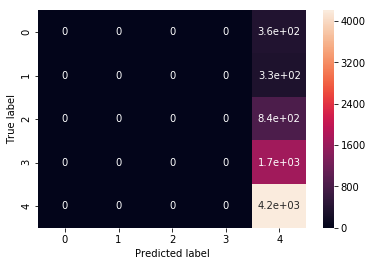

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data_loader.y_test[:-2], predictions)
sns.heatmap(cm,annot = True)
plt.xlabel("Predicted label")
plt.ylabel("True label")

### 3.3 Binary dataset with glove embedding

In [5]:
data_loader = AmznDataLoader(path ='./data/sst2.txt', maxSeqLength = 20)

In [10]:
callbacks = [
    ('es1',EpochScoring('accuracy')),
    ('lrs',LRScheduler()),
    ('est',EarlyStopping())    
]
batch_size = 128
device = torch.device("cuda")
model = ReviewModel(ReviewModelParam).to(device)

In [8]:
ReviewModelParam["output_dim"] = 2
ReviewModelParam["max_length"] = 20
ReviewModelParam["random"] = False

In [9]:
# refresh parameters 
ReviewModelParam["first_dense_in"] = ReviewModelParam["max_length"]//2 * ReviewModelParam["rnn_hidden_size"]
ReviewModelParam["second_dense_in"] = ReviewModelParam["first_dense_out"]
ReviewModelParam["second_dense_out"] = ReviewModelParam["output_dim"]  ##depends on loss function

In [13]:
model = ReviewModel(ReviewModelParam).to(device)
net = NeuralNetClassifier(model,## change dimensionality
                          iterator_train__drop_last = True,
                          iterator_valid__drop_last = True, 
                          iterator_train__shuffle = True,
                          iterator_valid__shuffle = True,
                          max_epochs=100, 
                          criterion = nn.CrossEntropyLoss,
                          optimizer=optim.SGD,
                          lr = 0.01,
                          optimizer__param_groups = {('momentum', 0.5)},
                          batch_size = batch_size,
                          callbacks = callbacks,
                          device = device,verbose = 1
                          )

In [14]:
inputs = torch.from_numpy(data_loader.X_train).long().to(device)
labels = torch.tensor(data_loader.y_train.values).long().to(device)
net.fit(inputs, labels)

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.5172        0.6934       0.5172        0.6930  2.7385
      2      0.5234        0.6910       0.5234        0.6898  2.7158
      3      0.5359        0.6906       0.5359        0.6897  2.7081
      4      0.5422        0.6897       0.5422        0.6899  2.7064
      5      0.5258        0.6885       0.5258        0.6901  2.7189
      6      0.5469        0.6866       0.5469        0.6868  2.7082
      7      0.5273        0.6864       0.5273        0.6881  2.7914
      8      0.5492        0.6878       0.5492        0.6868  2.7099
      9      0.5516        0.6865       0.5516        0.6858  2.7094
     10      0.5492        0.6875       0.5492        0.6860  2.7139
     11      0.5320        0.6872       0.5320        0.6855  2.7079
     12      0.5500        0.6862       0.5500        0.6861  2.7103
     13      0.5570        0.6856 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ReviewModel(
    (embedding): Embedding(15017, 50)
    (drop1): Dropout(p=0.5)
    (conv1): Conv1d(50, 200, kernel_size=(4,), stride=(1,), padding=(2,))
    (conv2): Conv1d(50, 200, kernel_size=(5,), stride=(1,), padding=(2,))
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop2): Dropout(p=0.3)
    (rnn): GRU(400, 100)
    (fc1): Linear(in_features=1000, out_features=400, bias=True)
    (drop3): Dropout(p=0.15)
    (fc2): Linear(in_features=400, out_features=2, bias=True)
  ),
)

Though it takes more epochs to find the optimal, the model performs better in binary dataset than the previous one for learning from input information and seizing higher accuracy. The results might differ much if using different learning rate and optimizer. Next we would examine its performance on test dataset

In [15]:
inputs = torch.from_numpy(data_loader.X_test).long().to(device)
predictions = net.predict(inputs)

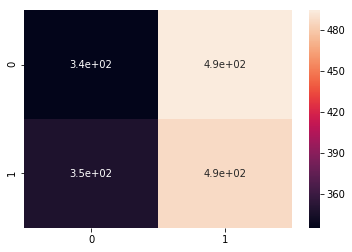

In [38]:
cm = confusion_matrix(data_loader.y_test[:-85], predictions)
sns.heatmap(cm,annot = True)

Unlike the previous model that divided all inputs to one class, the model does divide well in some cases, but the amount of FP and TN is also large. It is interesting to find that the predictions are divided to two classes evenly, though it achieve a satisfactory accuracy, so we can conclude that the improved accuracy may result from the imbalanced dataset that has more samples with label "1".

### 3.4 binary dataset with random embedding

In [39]:
ReviewModelParam["random"] = True

In [46]:
model = ReviewModel(ReviewModelParam).to(device)
net = NeuralNetClassifier(model,## change dimensionality
                          iterator_train__drop_last = True,
                          iterator_valid__drop_last = True, 
                          iterator_train__shuffle = True,
                          iterator_valid__shuffle = True,
                          max_epochs=100, 
                          criterion = nn.CrossEntropyLoss,
                          optimizer=optim.Adam,
                          lr = 0.01,
                          #optimizer__param_groups = {('momentum', 0.5)},
                          batch_size = batch_size,
                          callbacks = callbacks,
                          device = device,verbose = 1
                          )

In [47]:
inputs = torch.from_numpy(data_loader.X_train).long().to(device)
labels = torch.tensor(data_loader.y_train.values).long().to(device)
net.fit(inputs, labels)

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.5219       14.9198       0.5219        0.6925  2.8051
      2      0.5195        0.6926       0.5195        0.6925  2.8047
      3      0.5102        0.6925       0.5102        0.6931  2.8017
      4      0.5188        0.6924       0.5188        0.6924  2.8062
      5      0.5141        0.6925       0.5141        0.6929  2.8020
Stopping since valid_loss has not improved in the last 5 epochs.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ReviewModel(
    (embedding): Embedding(15017, 50)
    (drop1): Dropout(p=0.5)
    (conv1): Conv1d(50, 200, kernel_size=(4,), stride=(1,), padding=(2,))
    (conv2): Conv1d(50, 200, kernel_size=(5,), stride=(1,), padding=(2,))
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop2): Dropout(p=0.3)
    (rnn): GRU(400, 100)
    (fc1): Linear(in_features=1000, out_features=400, bias=True)
    (drop3): Dropout(p=0.15)
    (fc2): Linear(in_features=400, out_features=2, bias=True)
  ),
)

In [48]:
inputs = torch.from_numpy(data_loader.X_test).long().to(device)
predictions = net.predict(inputs)

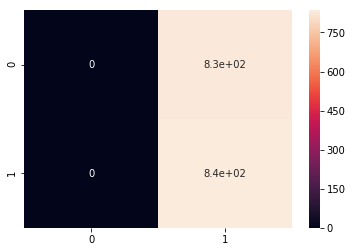

In [49]:
cm = confusion_matrix(data_loader.y_test[:-85], predictions)
sns.heatmap(cm,annot = True)

## Evaluation

-  The model doesn't work well for multiclass dataset while it makes sense for binary dataset though the results are not that ideal as paper shows. This might be caused by the differences of gradient calculation in two environment as the original code is written in Keras. Furthermore, we also adjust the code to fit parameters of functions in Pytorch.  

- Another issue is that the imbalanced dataset that the rating "5" takes up about 56% of the whole might lead to the inaccurate prediction. From the confusion matrix, it can be observed that only "big" class has True Positive cases but the other doesn't regardless of classes. We also implement \it{torch.utils.data.Sampler.WeightedRandomSampler}, and unfortunately it doesn't make sense.

- Alternatively, one way to deal with that might be using the imbalanced-learn library, which has built-in functions that can upsample or downsample the data, or even create new datapoints.

# Conclusions

We have tried a CNN-GRU neural network to compute sentiment analisys on a multiclass and binary dataset, with glove and random embeddings, to check whether the glove embeddings might outperform word2vec in predicting the sentiment. Unfornately the model doesn't show the difference when using different word embedding. The model works better in binary dataset though it is not that ideal and unable to achive high accuracy as paper shows. For multiclass dataset, the original model that our model is based on also doesn't achieve well and we still have rooms to improve.
From th project we learnt that different framework might affect results of experiment and to train a suitable model we have to consider computation resources, data quality and methods to deal with dataset.

## References and Citations

$[1]$ J.McAuley,Amazon Product Data, http://jmcauley.ucsd.edu/data/amazon/. 

$[2]$ Socher et al., 2013a, http://nlp.stanford.edu/sentiment/

$[3]$ Pennington, Jeffrey, Richard Socher, and Christopher Manning. "Glove: Global vectors for word representation." Proceedings of the 2014 conference on empirical methods in natural language processing (EMNLP). 2014. https://nlp.stanford.edu/projects/glove/

$[4]$ Wang, Xingyou, Weijie Jiang, and Zhiyong Luo. "Combination of convolutional and recurrent neural network for sentiment analysis of short texts." Proceedings of COLING 2016, the 26th International Conference on Computational Linguistics: Technical Papers. 2016.

## Code
The source code for the project is available at https://github.com/GabrieleSalvo/DeepLearningProject